# Total Energy Prediction - Kernel Ridge Regression

## Introduction

In this notebook we will machine-learn the relationship between descriptors of molecules and their total energy using kernel regression.

KRR is a one of the ML methods to perform regression (fitting).

In practice, we use kernel function $d$ that measures the distance between two data points.
With the function we build the kernel matrix:

\begin{equation}
K_{ij} =  d(M_{i}, M_{j}) - \alpha I_{ij}
\end{equation}

for all pairs of samples $M_i$ and $M_j$ in the training set. $I_{ij}$ is the identity matrix and $\alpha$ is a hyperparameter chosen between 0 and 1.

When we want to predict the output of a new sample or set of samples that were not in the training set, we need to first evaluate the distance between them and the training samples:

\begin{equation}
D_{ij} =  d(T_{i}, M_{j})
\end{equation}

where $T_i$ is one of the new samples. The output prediction $\mathbf{y_T}$ for the test set $T$ is obtained by:

\begin{equation}
\mathbf{y_T} = \mathbf{y_M} \cdot K^{-1} \cdot D^T
\end{equation}

where $\mathbf{y_M}$ is the vector of known outputs for the training set $M$.

The energy of ~134k molecules was calculated at the CCSD level.

## Setup

In [55]:
#resolve KRR dependency
import os
import os.path
if os.path.exists('pyKRR.py'):
    pass
else:
    !git clone https://github.com/reinimaurer1/ML-CSC-tutorial tut
    !mv tut/data data
    !mv tut/pyKRR.py ./
# IMPORTS
# INITIAL DEFINITIONS
from pyKRR import KRRsolver  # import our KRR solver object
import numpy, random
import numpy, math, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import load_npz

rm: cannot remove 'pyKRR.py': No such file or directory
Cloning into 'tut'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 372 (delta 25), reused 16 (delta 5), pack-reused 317
Receiving objects: 100% (372/372), 543.04 MiB | 35.43 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Checking out files: 100% (129/129), done.


Let's pick a descriptor. Allowed types are:

1. cnt: atom counts
2. bob: bag of bonds
4. soap: smooth overlap of atomic positions; choose from:
    1. soap.sum - all atoms summed together
    4. soap.mean - mean of all atom SOAP
    4. soap.centre - computed at the central point
5. mbtr: many-body tensor representation
6. cm: Coulomb matrix

In [56]:
# TYPE is the descriptor type
TYPE = "cnt"

#show descriptor details
print("\nDescriptor details")
desc = open("./data/descriptor."+TYPE.split('.')[0]+".txt","r").readlines()
for l in desc: print(l.strip())
print(" ")


Descriptor details
Atom counts:

Each molecule is represented by the count of each atom type found in it.
There will be 5 numbers for each molecule, giving the total H,C,N,O,F atoms.
This is effectively the chemical formula. Probably not a great descriptor!
 


and load the databases with the descriptors (input) and the correct charge densities (output). Databases are quite big, so we can decide how many samples to use for training.

In [57]:
# load input/output data
trainIn = load_npz("./data/energy.input."+TYPE+".npz").toarray()
trainOut = numpy.load("./data/energy.output.npy")
trainIn = trainIn.astype(dtype=numpy.float64, casting='safe')

# decide how many samples to take from the database
samples  = min(trainIn.shape[0], 1000) # change the number here!
vsamples = min(trainIn.shape[0]-samples,1000)
print("training samples:   "+str(samples))
print("validation samples: "+str(vsamples))

# split between training and validation
validIn = trainIn[samples:samples+vsamples]
validOut = trainOut[samples:samples+vsamples]

trainIn  = trainIn[0:samples]
trainOut = trainOut[0:samples]

# show the first few descriptors
print("\nDescriptors for the first 5 molecules:")
print(trainIn[0:5])

training samples:   1000
validation samples: 1000

Descriptors for the first 5 molecules:
[[10.  7.  2.  0.  0.]
 [ 9.  5.  3.  0.  0.]
 [ 4.  4.  1.  1.  3.]
 [ 7.  6.  1.  1.  0.]
 [ 9.  6.  1.  2.  0.]]


## Training

In the training phase we use the kernel function $d$ to measure the distance between all pairs of molecules in the dataset. The results for the kernel matrix:

\begin{equation}
K_{ij} =  d\left(M_{i}, M_{j}\right) - \alpha I_{ij}
\end{equation}

$I_{ij}$ is the identity matrix and $\alpha$ is a regularisation hyperparameter $\in \left[0,1\right]$.
The matrix is then inverted.

In [58]:
# create a new solver
solver = KRRsolver()

# set the regularisation hyperparameter
solver.alpha = 0.1

# call its training function with the training inputs and outputs
# WARNING: building the kernel matrix is O(N^2)
# WARNING: inverting the kernel matris is O(N^3)
# Keep the training set small
solver.Train(trainIn, trainOut)

KRR solver initialised.
Training completed.


The evaluation function computes the distance between each validation sample $T_i$ and the training ones $M_i$:

$$ D_{ij} =  d(T_{i}, M_{j}) $$

The predicted energies $E\left(T\right)$ are then given by:

$$ E\left( T \right) = E\left( M \right) \cdot K^{-1} \cdot D^T $$

Mean Abs Error (validation): 0.7001497583261415


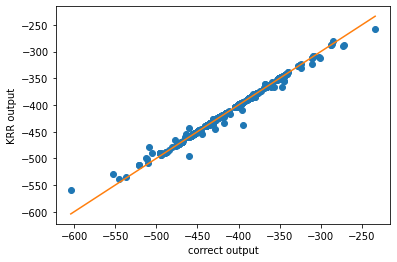

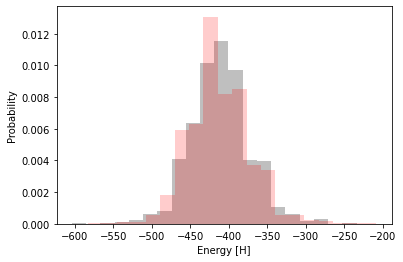

In [59]:
# get a list of predicted outputs for the validation inputs
predict = solver.Evaluate(validIn)

print("Mean Abs Error (validation): " + str((numpy.abs(predict-validOut)).mean()))

# do the regression plot
plt.plot(validOut, predict, 'o')
plt.plot([numpy.min(validOut),numpy.max(validOut)], [numpy.min(validOut),numpy.max(validOut)], '-')
plt.xlabel('correct output')
plt.ylabel('KRR output')
plt.show()

# check the distribution of energies in the training set
plt.hist(validOut, bins=20, density=True, alpha=0.5, facecolor='gray')
plt.hist(trainOut, bins=20, density=True, alpha=0.2, facecolor='red')
plt.xlabel("Energy [H]")
plt.ylabel("Probability")
plt.show()

# Exercises

### 1. Compare descriptors

Using the same training and validation set size, find which descriptor gives the smallest error.

### 2. Training set size

Choose a descriptor and investigate the effects of training set size on the quality of the model.

### 3. Combine with Principal Component Analysis - Advanced
Reduce the descriptor size with PCA (check the PCA.ipynb notebook) and train again. Can you get similar accuracy with a reduced input size?